# Comment évolue le trafic urbain au cours du temps ?

**Données :** Le jeu de donnée est issu de UTD-19 (https://utd19.ethz.ch/) produit par ETH paris (Ecole Polytechnique Fédérale de paris), qui compile des données de capteurs répartis dans des rues de 40 villes du monde. Ces données ont été enregistrées sur plusieurs années.
Les capteurs enregistrent à intervalles réguliers (la durée est variable suivant la ville et l'année) le nombre de véhicules qui sont passés et leur vitesse.
L'étude que nous réalisons est focalisée sur trois villes seulement, par souci de temps de calcul (le jeu de données d'origine est très lourd) : Paris, Toronto et Cagliari.

Quelques informations sur les villes en question :
- Paris : 2 millions d'habitants (hors agglomération)
- Toronto : 2,8 millions d'habitant (hors agglomération)
- Cagliari : petite ville d'Italie, 150 000 habitants

Il y a plusieurs tables de données :
#### 1. **detectors.csv :** contient des informations sur les capteurs
    - detid : Identificateur du détecteur
    - citycode : Nom de la ville dans lequel il a été placé
    - length : Longueur de la voie étudiée, en kilomètres
    - long : Longitude de la position du détecteur
    - lat : Latitude de la position du détecteur
    - lanes : Nombre de voies étudiées par ce détecteur
    - linkid : Identification de la voie étudiée
    - fclass : Classe de la route par OpenStreetMap
    - road : Nom de la route
    - limit : VItesse maximale de cette route, si disponible
    

#### 2. **links.csv :** contient des informations sur les voies
    - citycode
    - linkid
    - order : Ordre de la séquence de balises
    - long : Longitude de la balise
    - lat : Latitude de la balise


#### 3. **utd19.csv :** fichier principal qui contient toutes les observations des capteurs
    - city
    - detid
    - day : Jour d'enregistrement de la valeur
    - interval : Début de l'intervalle d'enregistrement de la valeur (exprimé en secondes à partir de minuit du jour en question)
    - flow : Nombre de voitures par heure pour le détecteur. Si le détecteur comprend plusieurs voies, le flow correspond au nombre de véhicules moyen par voie.
    - speed : Vitesse moyenne des véhicules dans l'intervalle d'enregistrement (km/h)
    - error : Erreur reportée dans la mesure


## I - Préparation des données

### a) Importation

Des variables en commun entre ces tables nous permettent de faire des jointures.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import geodatasets
import folium
import mapclassify

c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
df = pd.read_csv("data/utd19_u_finalsample.csv")
df.detid = df["detid"].astype({'detid': 'string'}) #on transforme la colonne en string, pour éviter toute confusion avec des int

detectors = pd.read_csv("data/detectors_public.csv")
detectors.detid = detectors["detid"].astype({'detid': 'string'})

C:\Users\FRO\AppData\Local\Temp\ipykernel_15020\2044036211.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/utd19_u_finalsample.csv")


Vérifions que l'échantillon du jeu de données comprend bien les 3 villes sélectionnées :

In [4]:
print(df["city"].unique())

['cagliari' 'paris' 'toronto']


Affichage du dataframe principal :

In [5]:
df.head()

Unnamed: 0         day  interval detid   flow    occ  error      city  \
0     9907074  2016-05-30         0     1  200.0  0.020    NaN  cagliari   
1     9907075  2016-05-30       180     1  220.0  0.015    NaN  cagliari   
2     9907076  2016-05-30       360     1  280.0  0.025    NaN  cagliari   
3     9907077  2016-05-30       540     1  260.0  0.025    NaN  cagliari   
4     9907078  2016-05-30       720     1  220.0  0.020    NaN  cagliari   

   speed  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN

### b) - Première visualisation

**Affichons maintenant une carte pour identifier les emplacements des détecteurs**

In [3]:
from shapely.geometry import Point

detect_city = detectors[detectors['citycode'].isin(['paris', 'toronto', 'cagliari'])].reset_index(drop=True)

group_detect = df.groupby(['city', 'detid']).mean(numeric_only=True).reset_index()

In [4]:
detect_city = detect_city.merge(group_detect[['city', 'detid', 'flow']], how='inner', left_on = ('citycode', 'detid'), right_on=('city', 'detid'))

In [5]:
point = [Point(detect_city.loc[i, 'long'], detect_city.loc[i, 'lat']) for i in range(len(detect_city))]

road = list(detect_city['road'])
detecteur_id = list(detect_city['detid'])
vitesse_limit = list(detect_city['limit'])
nb_voies = list(detect_city['lanes'])
nb_voiture_moyen_total = list(detect_city['flow'] * detect_city['lanes'])

d = {'road': road , 'detecteur_id':detecteur_id, 'vitesse_limit': vitesse_limit, 'nb_voies':nb_voies,'nb_voiture_moyen_total': nb_voiture_moyen_total, 'geometry':point }
gdf = geopandas.GeoDataFrame(d, crs="EPSG:4326")

In [6]:
gdf.explore( 'nb_voiture_moyen_total',
    cmap ="Wistia",  # use red color on all points
    marker_kwds=dict(radius=10, fill=True),  # make marker radius 10px with fill
    tooltip="road",  
    tooltip_kwds=dict(labels=False),  # do not show column label in the tooltip
    popup=["detecteur_id", 'nb_voies', 'vitesse_limit', 'nb_voiture_moyen_total'], 
    name="groceries",  # name of the layer in the map
)

c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\geopandas\explore.py:400: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(gdf[column]):


### c) Création de nouvelles colonnes, organisation du data frame

Transformons maintenant les données de sorte à avoir des intervalles de taille homogène (1h) et de sorte à tenir compte du nombre de voies. 

Pour cela, commençons par ajouter une colonne hour qui spécifie l'heure correspondante à l'intervalle.

In [7]:
old_df = df.copy()
df = old_df.copy()

bins = [i * 300 * 12 for i in range(0,25)]
labels = [(i)%24 for i in range(0,24)]
df['hour'] = pd.cut(df.interval, bins=bins, labels=labels, include_lowest=True)

On crée ensuite une colonne `real_flow` qui correspond à `flow * nb_voies` étant donné que le flux est divisé par le nombre de voies.

In [8]:
df = df.merge(detectors[["citycode", "detid", "lanes"]], how='inner', left_on=("city", "detid"), right_on=("citycode", "detid"))

df["real_flow"] = df.flow * df.lanes

On va maintenant faire la somme des flux par heure.

Ajoutons également une colonne "full_time" qui correspond à la date concaténée à l'heure (pour avoir une mesure unique dans les graphs).

Transformons les colonnes "day" et "full_time" en colonnes dates de pandas :

In [12]:
df

Unnamed: 0         day  interval     detid   flow    occ  error  \
0           9907074  2016-05-30         0         1  200.0  0.020    NaN   
1           9907075  2016-05-30       180         1  220.0  0.015    NaN   
2           9907076  2016-05-30       360         1  280.0  0.025    NaN   
3           9907077  2016-05-30       540         1  260.0  0.025    NaN   
4           9907078  2016-05-30       720         1  220.0  0.020    NaN   
...             ...         ...       ...       ...    ...    ...    ...   
5410932   127060823  2016-09-30     81900  N31111Y1  356.0  0.037    NaN   
5410933   127060824  2016-09-30     82800  N31111Y1  272.0  0.028    NaN   
5410934   127060825  2016-09-30     83700  N31111Y1  320.0  0.035    NaN   
5410935   127060826  2016-09-30     84600  N31111Y1  260.0  0.025    NaN   
5410936   127060827  2016-09-30     85500  N31111Y1  328.0  0.033    NaN   

             city  speed hour  citycode  lanes  real_flow  
0        cagliari    NaN    0  cagliari    1.0      200.0  
1        cagliari    NaN    0  cagliari    1.0      220.0  
2        cagliari    NaN    0  cagliari    1.0      280.0  
3        cagliari    NaN    0  cagliari    1.0      260.0  
4        cagliari    NaN    0  cagliari    1.0      220.0  
...           ...    ...  ...       ...    ...        ...  
5410932   toronto    NaN   22   toronto    1.0      356.0  
5410933   toronto    NaN   22   toronto    1.0      272.0  
5410934   toronto    NaN   23   toronto    1.0      320.0  
5410935   toronto    NaN   23   toronto    1.0      260.0  
5410936   toronto    NaN   23   toronto    1.0      328.0  

[5410937 rows x 13 columns]

In [9]:
df = df.groupby(by=["city", "detid", "day", "hour"], observed=True).agg({"real_flow": "sum", "lanes": "max", "flow": "sum"}).reset_index()
df["full_time"] = df["day"] + "-" + df["hour"].astype(str)

df.day = pd.to_datetime(df.day, format="%Y-%m-%d")
df.full_time = pd.to_datetime(df.full_time, format="%Y-%m-%d-%H")

df

city     detid        day hour  real_flow  lanes    flow  \
0        cagliari         1 2016-05-16    0     3360.0    1.0  3360.0   
1        cagliari         1 2016-05-16    1      660.0    1.0   660.0   
2        cagliari         1 2016-05-16    2      140.0    1.0   140.0   
3        cagliari         1 2016-05-16    3      300.0    1.0   300.0   
4        cagliari         1 2016-05-16    4     1100.0    1.0  1100.0   
...           ...       ...        ...  ...        ...    ...     ...   
1887008   toronto  N31221D2 2017-01-31   19      508.0    1.0   508.0   
1887009   toronto  N31221D2 2017-01-31   20      392.0    1.0   392.0   
1887010   toronto  N31221D2 2017-01-31   21      308.0    1.0   308.0   
1887011   toronto  N31221D2 2017-01-31   22      272.0    1.0   272.0   
1887012   toronto  N31221D2 2017-01-31   23      100.0    1.0   100.0   

                  full_time  
0       2016-05-16 00:00:00  
1       2016-05-16 01:00:00  
2       2016-05-16 02:00:00  
3       2016-05-16 03:00:00  
4       2016-05-16 04:00:00  
...                     ...  
1887008 2017-01-31 19:00:00  
1887009 2017-01-31 20:00:00  
1887010 2017-01-31 21:00:00  
1887011 2017-01-31 22:00:00  
1887012 2017-01-31 23:00:00  

[1887013 rows x 8 columns]

Créons des colonnes pour donner pour chaque date, le jour de la semaine, le mois, etc :

In [10]:
df['dayOfWeek'] = df['full_time'].dt.day_name()
df['dayOfMonth'] = df['full_time'].dt.month_name()
df['year'] = df['full_time'].dt.year

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

## II - Visualisations

Exemple de l'évolution du traffic à un capteur pour un jour donné à Paris.

Dans ce cas précis, il y a 24 mesures dans une journée (chaque intervalle de temps correspond donc à 1 heure).

**Regardons dans un premier temps quelle route était controlée par ce capteur :**

In [16]:
print(detectors[(detectors["citycode"] == "paris") & (detectors["detid"] == "1")])

      detid    length       pos   fclass                      road limit  \
16074     1  0.323538  0.285077  primary  Quai François Mitterrand   NaN   

      citycode  lanes  linkid      long        lat  
16074    paris    5.0    62.0  2.334171  48.859959  


Il s'agit d'une route qui longe le musée du Louvre. Sa classe "primary" nous indique que c'est une route principale. On voit par ailleurs qu'elle est composée de 5 voies.

<AxesSubplot:xlabel='hour', ylabel='real_flow'>

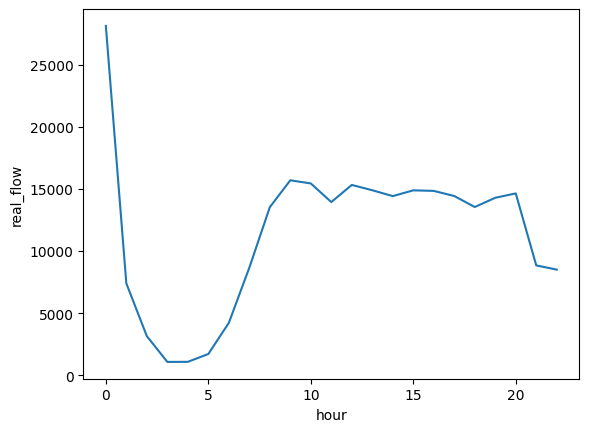

In [17]:
sns.lineplot(x=df["hour"], y="real_flow",
             data=df[(df["day"] == "2016-02-03") & (df["city"] == "paris") & (df["detid"] == "1")])

D'une façon générale, **le nombre de mesures par jour dépend de la ville et d'autres facteurs** (capteur, date, etc).

Affichons maintenant une courbe d'évolution du trafic à Paris pour une semaine en 2016.

c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

Text(0, 0.5, 'flux réel')

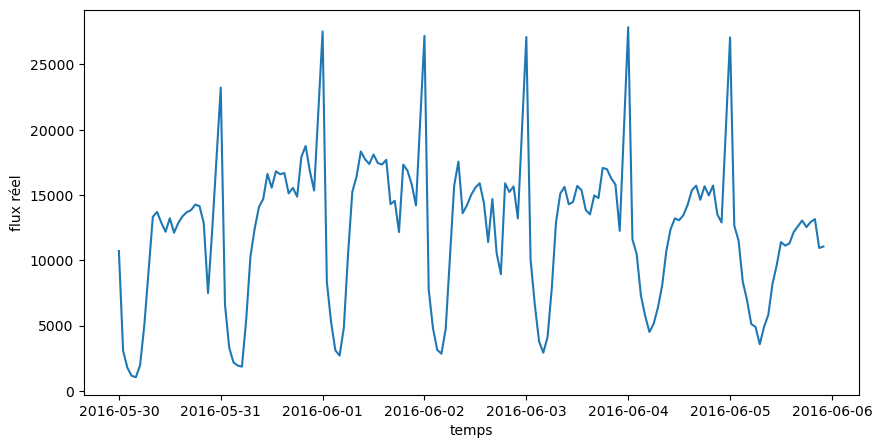

In [12]:
paris_one_week_2016 = df[(df["day"].isin(["2016-05-30", "2016-05-31", "2016-06-01", "2016-06-02", "2016-06-03", "2016-06-04", "2016-06-05"])) & (df["city"] == "paris") & (df["detid"] == "1")]

plt.figure(figsize=(10, 5))

paris_plot = sns.lineplot(x="full_time", y=paris_one_week_2016["real_flow"].values.flatten(), data=paris_one_week_2016)

paris_plot.set_xlabel("temps")
paris_plot.set_ylabel("flux réel")

Comparons maintenant une même semaine (du lundi au vendredi) de trafic pour un capteur de Paris et un capteur de Cagliari.

**Dans un premier temps, voyons à quelles rues correspondent les capteurs d'identification 38 dans ces 2 villes.**

In [19]:
print(detectors[(detectors["citycode"].isin(["paris", "cagliari"])) & (detectors["detid"] == "48")])

      detid    length       pos     fclass                road limit  \
2807     48  0.117092  0.036837  secondary  Via Sidney Sonnino    50   
16101    48  0.146995  0.099767  secondary       Rue du Renard   NaN   

       citycode  lanes  linkid      long        lat  
2807   cagliari    1.0    34.0  9.121638  39.218384  
16101     paris    3.0   198.0  2.352437  48.859273  


Il s'agit de deux routes secondaires.

c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

Text(0, 0.5, 'flux réel')

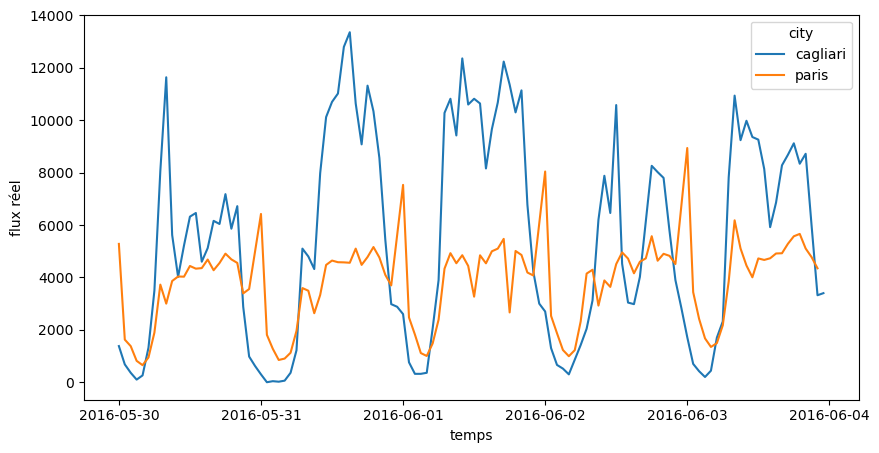

In [13]:
two_cities_one_week_2016 = df[(df["day"].isin(["2016-05-30", "2016-05-31", "2016-06-01", "2016-06-02", "2016-06-03"])) & (df["detid"] == "48")]

plt.figure(figsize=(10, 5))

comparison_plot = sns.lineplot(x='full_time', y=two_cities_one_week_2016["real_flow"].values.flatten(), hue='city', 
             data=two_cities_one_week_2016)

comparison_plot.set_xlabel("temps")
comparison_plot.set_ylabel("flux réel")

Nous observons que les routes ont des nombres de passage différents. La ville de Caglari est bien plus petite que Paris, ce qui pourrait sembler étonnant au vu des résultats (la ciruclation dans Paris sur cet axe est plus faible). 

Cependant, la densité de circulation à Paris (et donc les embouteillages que cela génère) pourrait expliquer cette proximité d'échelle.

### En graph rond

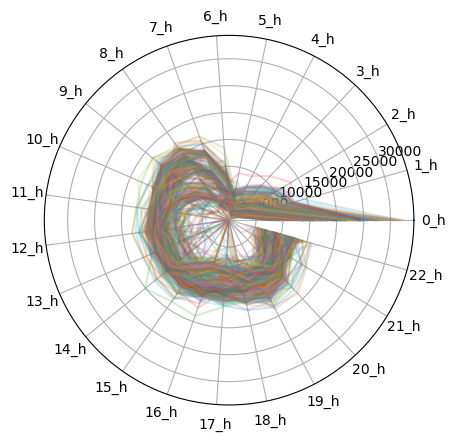

In [14]:
df_group_paris = df[(df['city'] =='paris') & (df['detid'] == '1') ].groupby(['city','day', 'hour'], observed='False')['real_flow'].mean().reset_index()

day_list = df_group_paris['day'].unique()
for i in range(len(day_list)):
    data = df_group_paris[df_group_paris['day'] == day_list[i]]
    if len(data) == 23:
        n = 23
        ax = plt.subplot(111, projection='polar') 
        rads = np.linspace(0, 2 * np.pi, n ,endpoint=False)
        ax.plot(rads, data['real_flow'], alpha=0.2)
        label = [j for j in data['hour']]
        label = [str(nombre)+ '_h' for nombre in label]
        ax.set_xticks(np.linspace(0, 2* np.pi, n, endpoint=False))
        ax.set_xticklabels(label)

## III - Modèles paramétriques

| Modèle | Formule |
| --- | --- |
| Régression linéaire | $Y = \beta_0 + \sum_{i=1}^n \beta_i X_i + \epsilon$ |
| Régression polynomiale | $Y = \beta_0 + \sum_{i=1}^n \beta_i X_i^i + \epsilon$ |
| GAM | On cherche les $f_i$ pour satisfaire : $g(\mathbb{E}(Y)) = \beta_0 + \sum_{i=1}^n f_i(X_i)$ |

### a) Régression linéaire

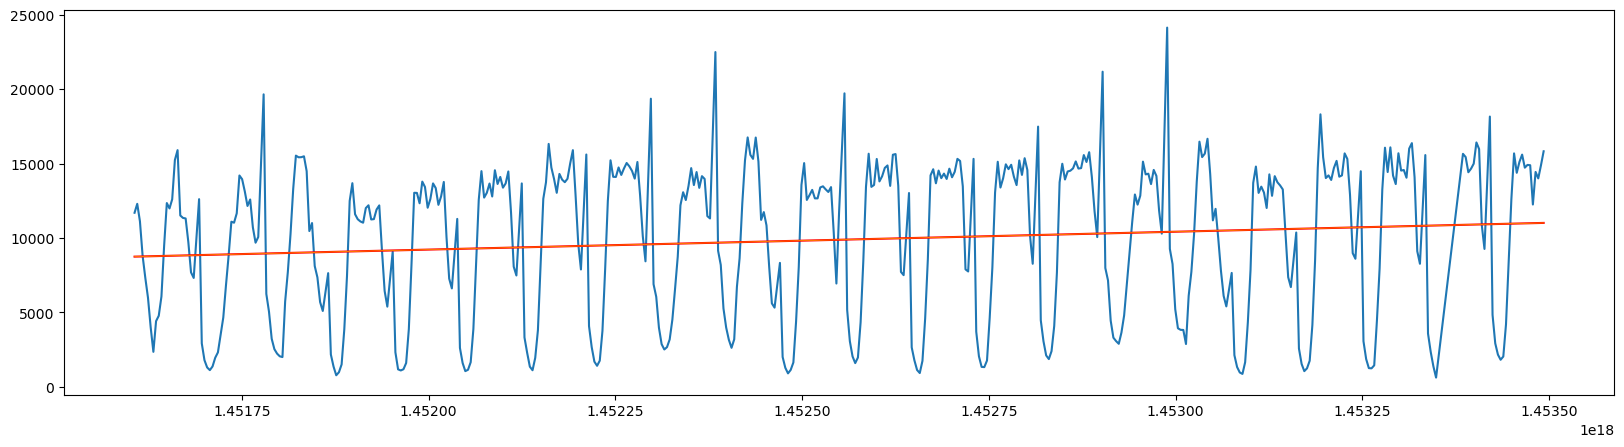

In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

obs_df_ma = df[(df.city == "paris") & (df.detid == "1")].head(504)

x = obs_df_ma.full_time.astype('int64')
y = obs_df_ma.real_flow
xx = np.linspace(x.min(), x.max(), 400)

plt.figure(figsize=(20, 5))

poly = np.polyfit(x, y, deg=1)
y_pred = np.polyval(p=poly, x=x)
plt.plot(x, y)
plt.plot(x, y_pred, color='r', markersize=6 )
plt.plot(xx, np.polyval(poly, xx), color='orange', linewidth=0.5)

plt.show()

Il est clair que la régression linéaire ne se prête pas du tout à nos données, à cause de la périodicité que l'on a.

Cependant, si on fait la somme cumulée du flux, on a une bonne régression linéaire :

[ 2.66217482e-09 -3.86454076e+09]


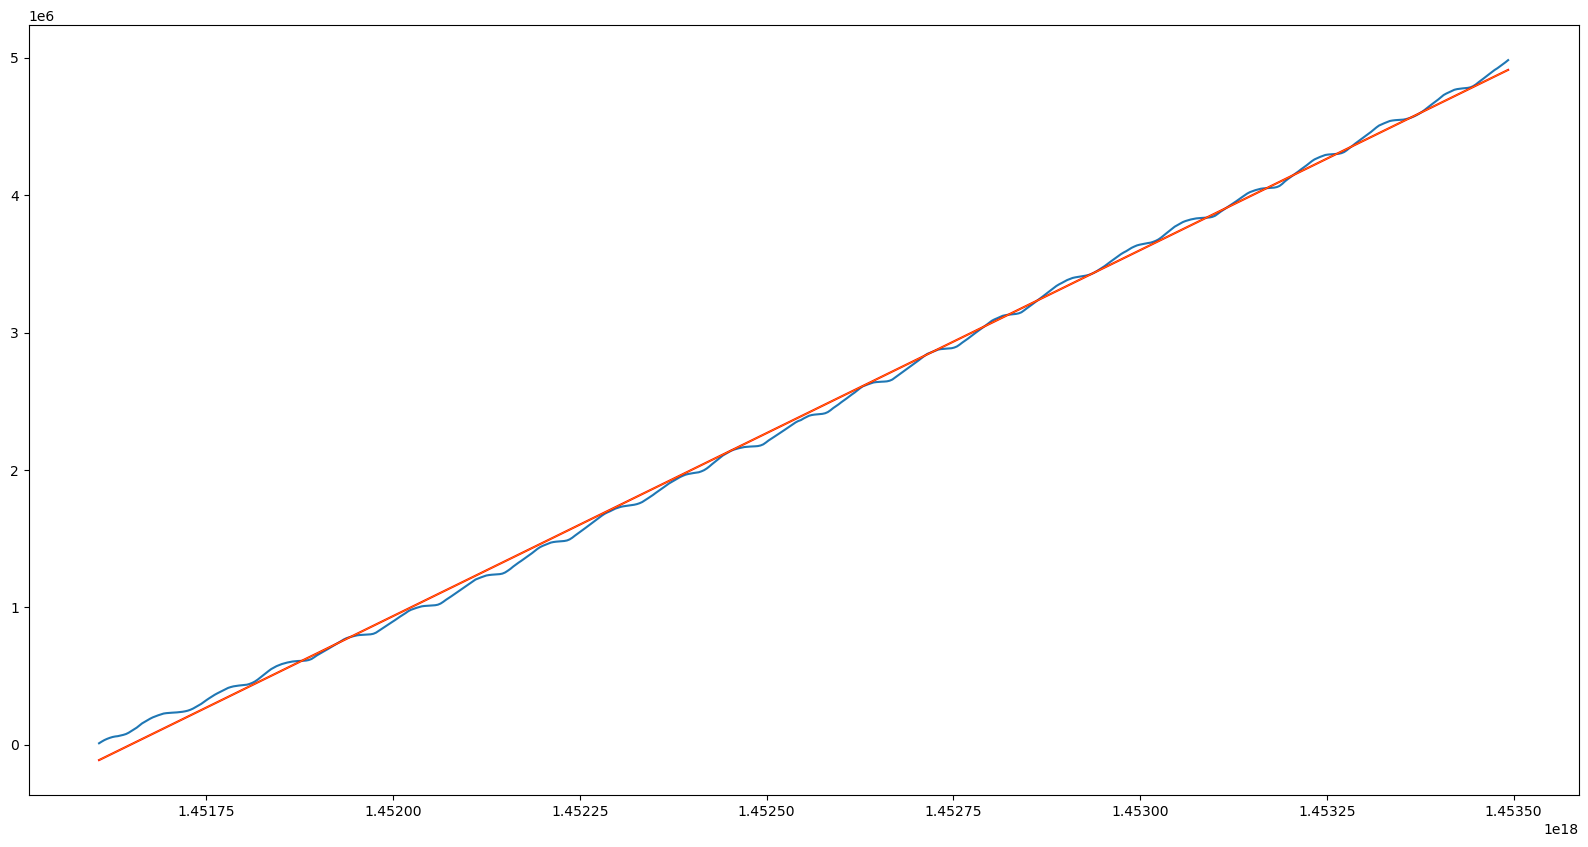

In [16]:
x = obs_df_ma.full_time.astype('int64')
y2 = np.cumsum(obs_df_ma.real_flow)
xx = np.linspace(x.min(), x.max(), 400)

plt.figure(figsize=(20, 10))

poly = np.polyfit(x, y2, deg=1)
print(poly)
y_pred = np.polyval(p=poly, x=x)
plt.plot(x, y2)
plt.plot(x, y_pred, color='r', markersize=6 )
plt.plot(xx, np.polyval(poly, xx), color='orange', linewidth=0.5)

plt.show()

### b) Régression polynomiale

Testons plusieurs degrés de polynômes : 2, 3 et 4

mse pour degre 2 = 25856609.166016072
mse pour degre 3 = 25793730.90085305
mse pour degre 4 = 25793701.624723807


C:\Users\vince\AppData\Local\Temp\ipykernel_15816\3574005786.py:15: RankWarning: Polyfit may be poorly conditioned
  plt.plot(x, get_y_pred(4), label="Degré 4")


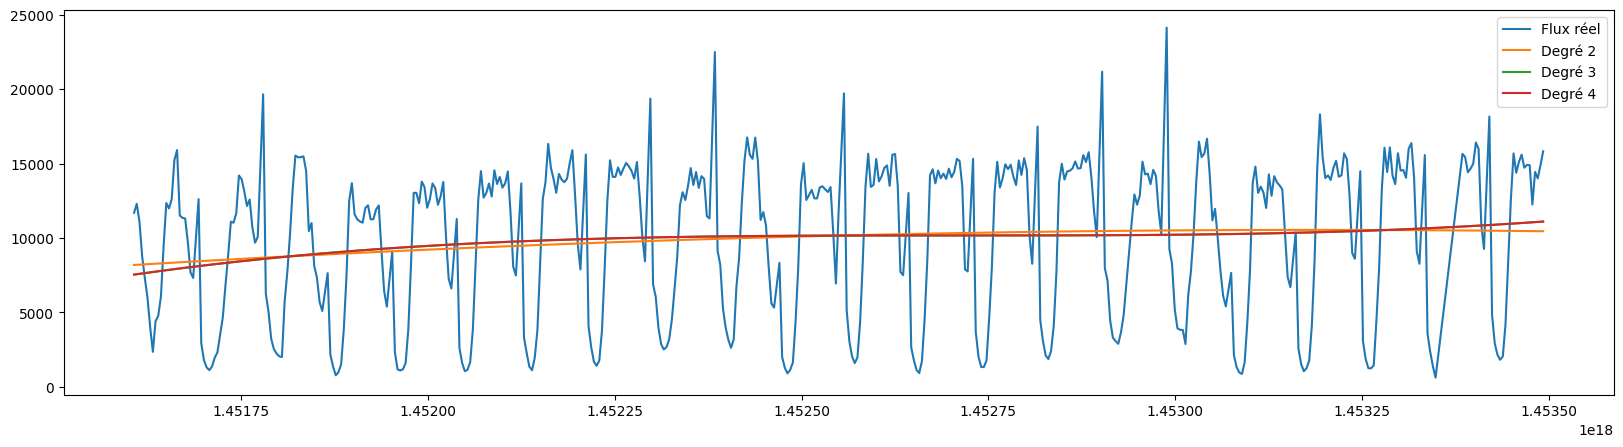

In [24]:
def get_y_pred(deg):
    poly = np.polyfit(x, y, deg=deg) 
    y_pred = np.polyval(poly, x)

    mse = mean_squared_error(y_true=y, y_pred=y_pred)
    print(f"mse pour degre {deg} = {mse}")

    return (y_pred)

plt.figure(figsize=(20, 5))

plt.plot(x, y, label="Flux réel")
plt.plot(x, get_y_pred(2), label="Degré 2")
plt.plot(x, get_y_pred(3), label="Degré 3")
plt.plot(x, get_y_pred(4), label="Degré 4")
plt.legend()
plt.show()

Comme pour la régression linéaire, cela ne se prête pas du tout à nos données.

### c) Modèle GAM 

In [25]:
from pygam import LinearGAM

In [26]:
x = obs_df_ma['real_flow'] # avec cette option ca marche moins bien 
y = obs_df_ma['hour']

y = obs_df_ma.full_time.astype('int64')  # si on utilise ce choix ca marche mieux car plus lineaire
x = np.cumsum(obs_df_ma.real_flow)

gam = LinearGAM(lam=0.1).fit(x, y) # le parametre lam pour reduire la complexité , mais ici ca ne suffit pas on a trop de bruit


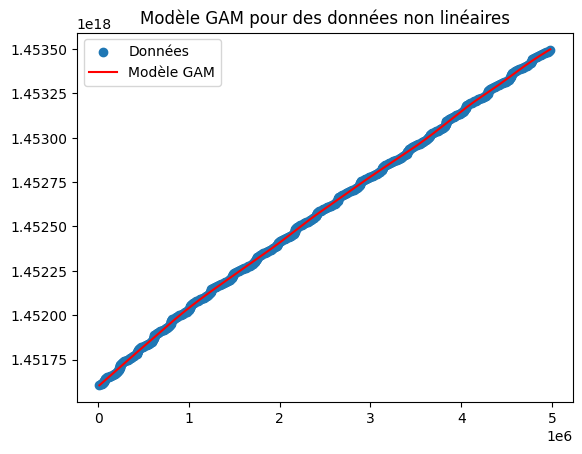

In [27]:
# Afficher le modèle
plt.figure()
plt.scatter(x, y, label='Données')
plt.plot(x, gam.predict(x), label='Modèle GAM', color='red')
plt.legend()
plt.title('Modèle GAM pour des données non linéaires')
plt.show()

## IV - Modèles non paramétriques

L'objectif de ces modèles est d'arriver à bien lisser les courbes en enlevant le bruit.

### a) Moyennes mobiles
#### 1. Théorie

Formules :
- Moyenne mobile simple (on donne la même importance à toutes les valeurs du passé) : $$\hat{x_n} = \frac{1}{N} \sum_0^{N - 1} x_{n - k}$$ 

- Moyenne mobile exponentielle (on donne plus d'importance aux valeurs les plus récentes, avec une décroissance exponentielle) : $$\hat{x_n} = \sum_0^{\infty} \alpha (1 - \alpha)^n x_{t - n}$$

#### 2. Mise en pratique

Nous allons mettre en pratique cela sur les de Paris pour un détecteur donné pour 3 semaines. Prenons des mémoires k différentes pour des moyennes mobiles simples (elles utiliseront seulement les k précédentes observations).

In [28]:
from sklearn.metrics import mean_absolute_error

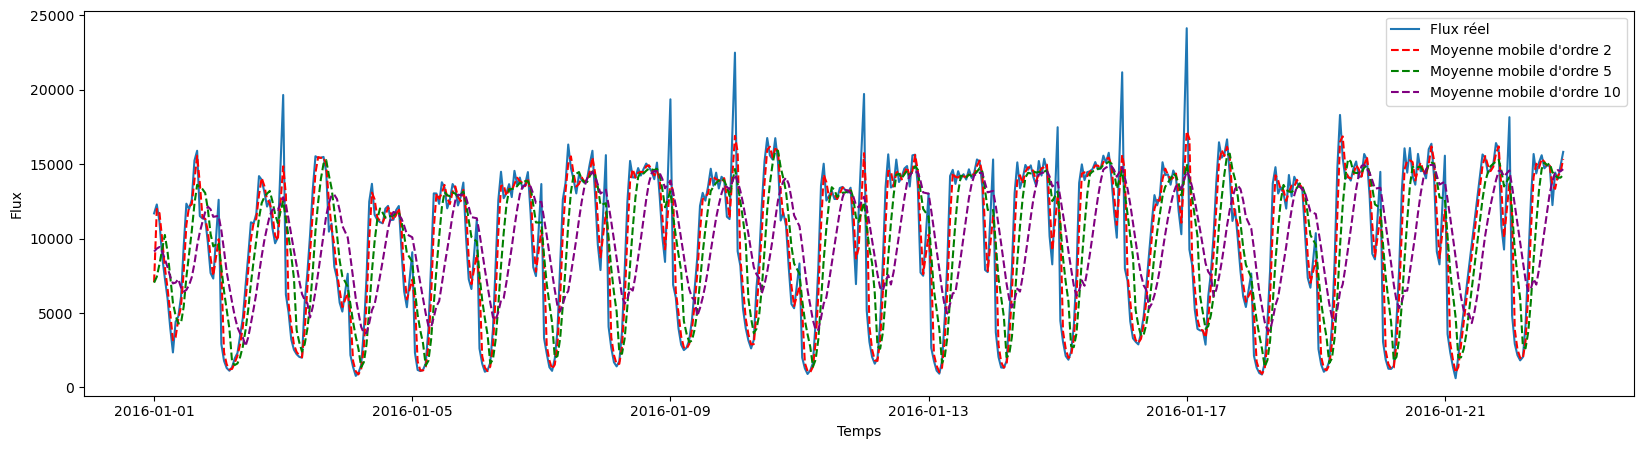

In [71]:
obs_df_ma["moyenne_mobile2"] = pd.Series(df.real_flow).rolling(2).mean()
obs_df_ma["moyenne_mobile5"] = pd.Series(df.real_flow).rolling(5).mean()
obs_df_ma["moyenne_mobile10"] = pd.Series(df.real_flow).rolling(10).mean()

obs_df_ma.index = obs_df_ma.full_time

plt.figure(figsize=(20,5))
plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")

plt.plot(obs_df_ma.index, obs_df_ma["moyenne_mobile2"], label=f"Moyenne mobile d'ordre 2", linestyle="dashed", c="red")
plt.plot(obs_df_ma.index, obs_df_ma["moyenne_mobile5"], label=f"Moyenne mobile d'ordre 5", linestyle="dashed", c="green")
plt.plot(obs_df_ma.index, obs_df_ma["moyenne_mobile10"], label=f"Moyenne mobile d'ordre 10", linestyle="dashed", c="purple")

plt.xlabel("Temps")
plt.ylabel("Flux")
plt.legend()
plt.show() 

Moyenne mobile exponentielle (avec $\alpha \in \{0.3, 0.5, 1\}$, le paramètre de décroissance):

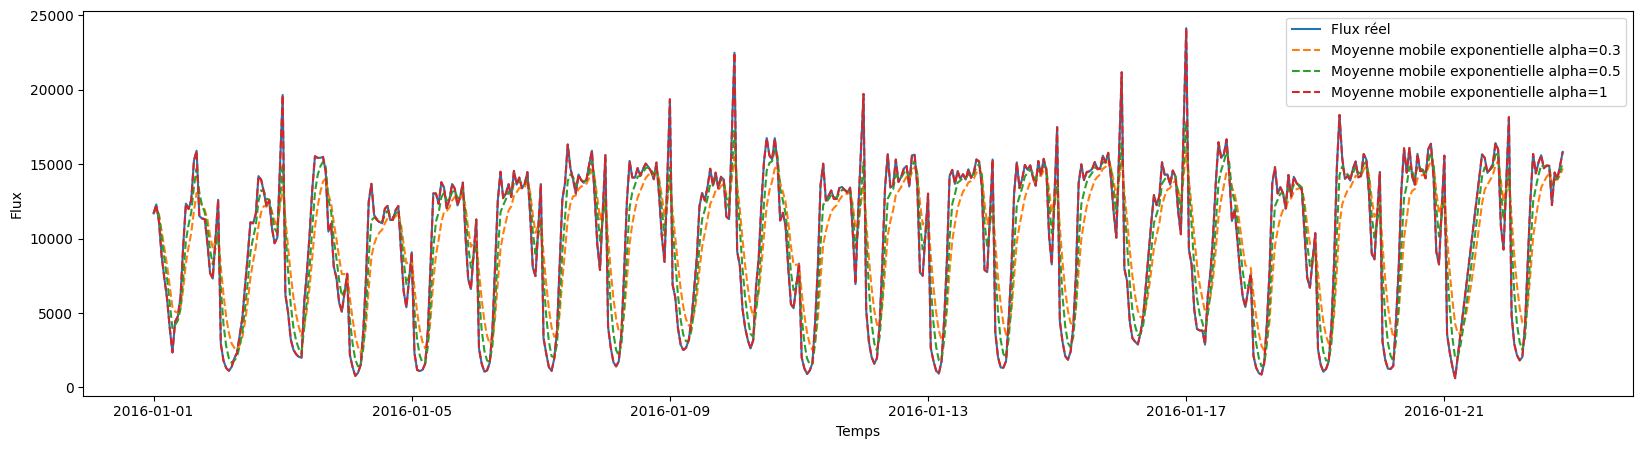

In [30]:
plt.figure(figsize=(20,5))

obs_df_ma["moyenne_mobile_expo05"] = pd.Series(obs_df_ma.real_flow).ewm(alpha=0.5).mean()
obs_df_ma["moyenne_mobile_expo03"] = pd.Series(obs_df_ma.real_flow).ewm(alpha=0.3).mean()
obs_df_ma["moyenne_mobile_expo1"] = pd.Series(obs_df_ma.real_flow).ewm(alpha=1).mean()

plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")
plt.plot(obs_df_ma.index, obs_df_ma.moyenne_mobile_expo03, label="Moyenne mobile exponentielle alpha=0.3", linestyle="dashed")
plt.plot(obs_df_ma.index, obs_df_ma.moyenne_mobile_expo05, label="Moyenne mobile exponentielle alpha=0.5", linestyle="dashed")
plt.plot(obs_df_ma.index, obs_df_ma.moyenne_mobile_expo1, label="Moyenne mobile exponentielle alpha=1", linestyle="dashed")
plt.xlabel("Temps")
plt.ylabel("Flux")
plt.legend()
plt.show() 

### b) Lissage exponentiel

#### 1. Théorie

Le lissage exponentiel repose sur un principe similaire aux moyennes mobiles exponentielles, avec une décroissance d'importance exponentielle.

Nous utiliserons un lissage triple (méthode de Holt-Winters) car celui-ci tient compte des tendances (deux paramètres de lissage : $\alpha, \beta$).

Formule (lissage simple) par récurrence : 
$$s_t =     
    \left\{
        \begin{array}{ll}
            y_0 \textrm{ si } t = 0 \\
            \alpha * y_t + (1 - \alpha) * s_{t - 1}
        \end{array}
    \right.
$$

Formules (lissage triple) :

$$s_1 = y_1 \\
\sigma_1 = y_1 - y_0 \\ \\

s_t = \alpha * y_t + (1 - \alpha) * (s_{t - 1} + \sigma_{t - 1}) \\
\sigma_t = \beta * (s_t - s_{t - 1}) + (1 - \beta) * \sigma_{t - 1}
$$

In [31]:
from statsmodels.tsa.api import SimpleExpSmoothing

obs_df_ma.index = obs_df_ma.full_time

exponential_smooth_df = obs_df_ma[["real_flow"]] #on garde un data frame avec le real_flow et en index full_time
exponential_smooth_df.index = pd.DatetimeIndex(exponential_smooth_df.index)
exponential_smooth_df = exponential_smooth_df.asfreq("h")

let = SimpleExpSmoothing(exponential_smooth_df).fit()

exponential_smooth_df["lissage_expo"] = let.forecast(len(exponential_smooth_df))
print(exponential_smooth_df.lissage_expo)

# Je n'ai pas réussi à appliquer le modèle, probablement à cause de valeurs manquantes ?

full_time
2016-01-01 00:00:00   NaN
2016-01-01 01:00:00   NaN
2016-01-01 02:00:00   NaN
2016-01-01 03:00:00   NaN
2016-01-01 04:00:00   NaN
                       ..
2016-01-22 16:00:00   NaN
2016-01-22 17:00:00   NaN
2016-01-22 18:00:00   NaN
2016-01-22 19:00:00   NaN
2016-01-22 20:00:00   NaN
Freq: H, Name: lissage_expo, Length: 525, dtype: float64


c:\Users\vince\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### c) Polynômes locaux

#### 1. Théorie

La régression par polynômes locaux consiste à trouver (on fait une régression locale) des polynômes de faibles degrés à des sous-ensembles de points (appelés fenêtres), de sorte à bien s'adapter aux données de façon locale.

On peut utiliser différentes méthodes pour trouver les coefficients de ces polynômes. Une méthode performante (et très utilisée) est celle de **Savitzky–Golay**.

#### 2. Mise en pratique

Nous allons fixer le degré des polynômes locaux à 2, 3 ici et une taille de fenêtre de 5, 10 (le nombre de coefficients) :

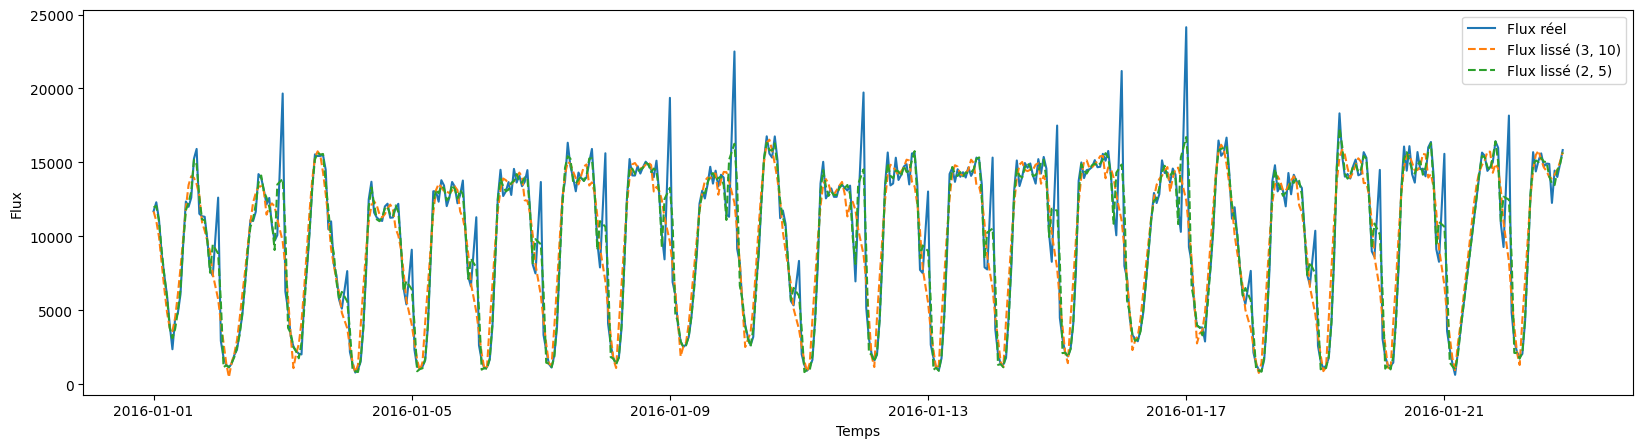

In [32]:
from scipy import signal

flow_smooth = signal.savgol_filter(obs_df_ma.real_flow, window_length=10, polyorder=3, mode="nearest")
flow_smooth2 = signal.savgol_filter(obs_df_ma.real_flow, window_length=5, polyorder=2, mode="nearest")

plt.figure(figsize=(20,5))

plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")
plt.plot(obs_df_ma.index, flow_smooth, label="Flux lissé (3, 10)", linestyle="dashed")
plt.plot(obs_df_ma.index, flow_smooth2, label="Flux lissé (2, 5)", linestyle="dashed")
plt.xlabel("Temps")
plt.ylabel("Flux")
plt.legend()
plt.show() 

### d) B-Splines

#### 1. Théorie

Un spline est une fonction polynomiale par morceaux définie sur un intervalle subdivisé en sous intervalles $[t_{i-1}, t_i]$ tels que $a = t_0 < t_1 < ... < t_{k-1} < t_k = b$

On définit un spline par la fonction $S_d$ (où d est l'ordre, cela correspond au degré maximal + 1) où :

$$S_d(t) = \sum_{i=1}^{k} P_i(t) 1_{[t_{i-1}, t_i]}(t)$$

Les $P_i$ sont les polynômes associés aux intervalles $[t_{i-1}, t_i]$ (de degré inférieur ou égal au max, mais pas nécessairement égal !).

Les **$t_i$** sont appelés les noeuds.

*Remarque :* Cette fonction est continue !

Les b-splines sont des collections de splines qui sont définis par récurrence :

$$b_{i,0}(t) = I_{[t_i - 1, t_i]}(t)$$

et : $b_{i, n}(t) = w_{i,n}(t) b_{i,n-1}(t) + (1 - w_{i+1,n}(t))b_{i+1,n-1}(t)$ pour $n \geq 1$

où $w_{i,n}(t) = \frac{t - t_i}{t_{j+n} - t_i}$ pour $t \neq t_{j+n}$

#### 2. Mise en pratique

On laisse scipy choisir automatiquement les noeuds (en lui indiquant 88 points pour la visualisation, ce qui correspond à 4 points par jour). Prenons des splines de degré 3.

C:\Users\vince\AppData\Local\Temp\ipykernel_15816\995355251.py:9: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  xx = pd.date_range(start='01/01/2016', end='23/01/2016', periods=88)


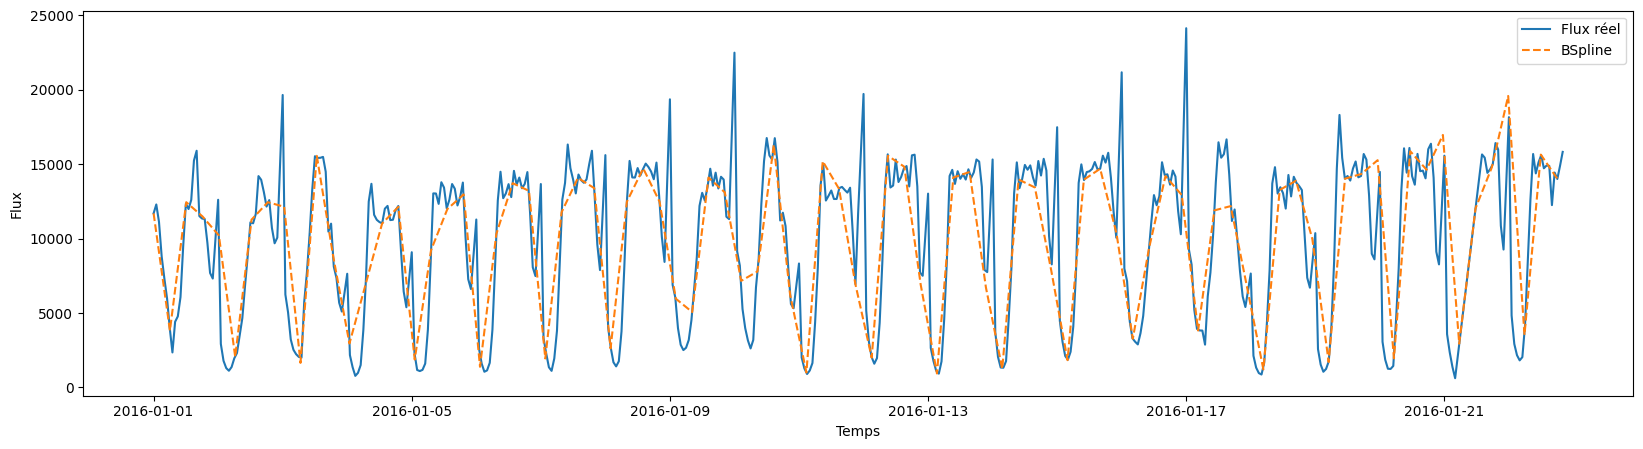

In [33]:
import scipy.interpolate as interpolate

t, c, k = interpolate.splrep(obs_df_ma.index, obs_df_ma.real_flow, s=0, k=3)
spl = interpolate.BSpline(t, c, k, extrapolate=False)

plt.figure(figsize=(20,5))
plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")

xx = pd.date_range(start='01/01/2016', end='23/01/2016', periods=88)

plt.plot(xx, spl(xx), label='BSpline', linestyle="dashed")
plt.xlabel("Temps")
plt.ylabel("Flux")
plt.legend()
plt.show() 

### Paramètres à optimiser pour les modèles

| Méthode | Paramètre(s) à optimiser | Valeur(s) choisie(s) dans nos exemples |
| --- | --- | --- |
| Moyenne Mobile | Ordre | Ordre faible (2) |
| Moyenne Mobile exponentielle | Paramètre de décroissance $\alpha$ | $\alpha$ = 0.5 |
| Polynômes locaux | Degré et taille de fenêtre | Degré = 3 et taille de fenêtre = 10 |
| B-Splines | Ordre | Ordre faible (2) |

## V - ACF, PACF

Affichons maintenant les fonctions ACF, PACF sur un échantillon de nos données (le flux dans Paris sur une durée déterminée).

### a) ACF

In [34]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

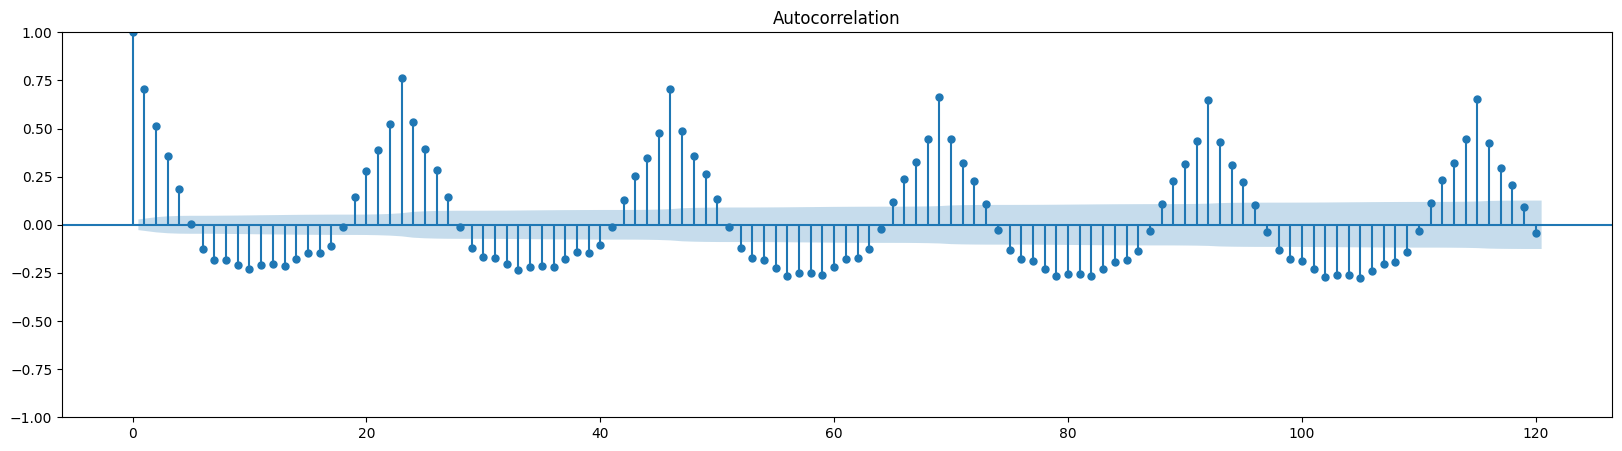

In [35]:
df_paris = df[(df['city'] =='paris')].copy().reset_index(drop=True)
x = df_paris.head(5000)['flow']

fig, ax = plt.subplots(figsize=(20, 5))
tsaplots.plot_acf(x, ax, lags=120)
plt.show()

On voit qu'il y a des cycles dans la fonction d'auto-corrélation, ce qui montre la saisonnalité de nos données, avec une répétition. La période vaut 21. Notre série temporelle n'est pas stationnaire.

### b) PACF

Avec la méthode de Yule-Walker, sans ajustement

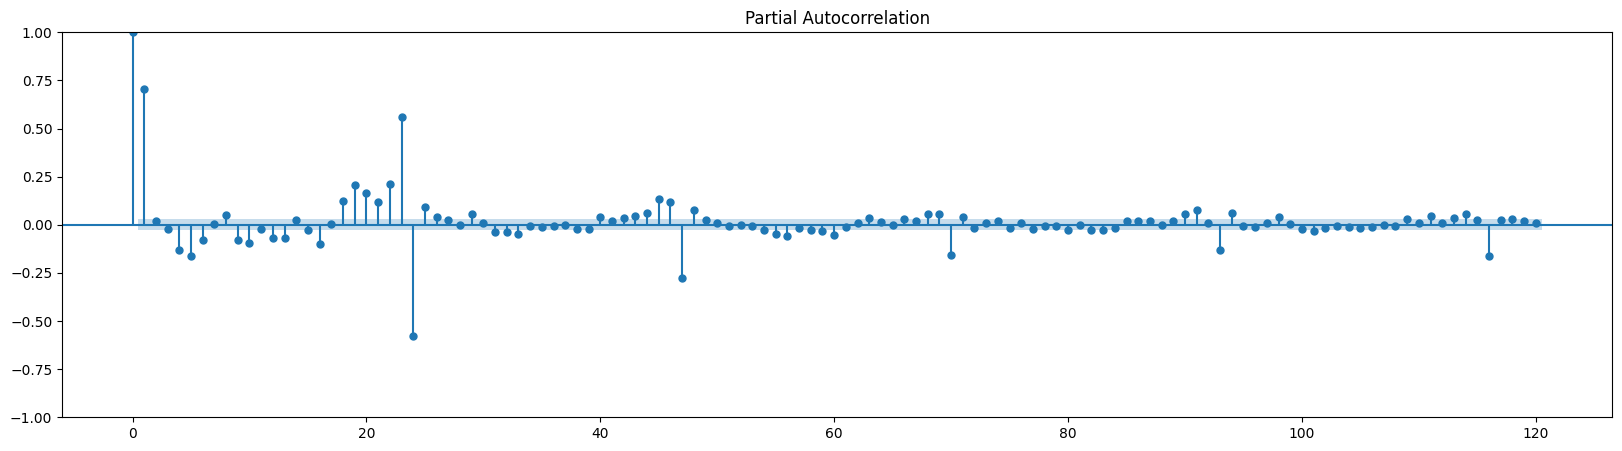

In [36]:
fig2, ax2 = plt.subplots(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(x, method="ywm", lags=120, ax=ax2)
plt.show()

Avec la méthode de Levinson-Durbin, avec correction du biais :

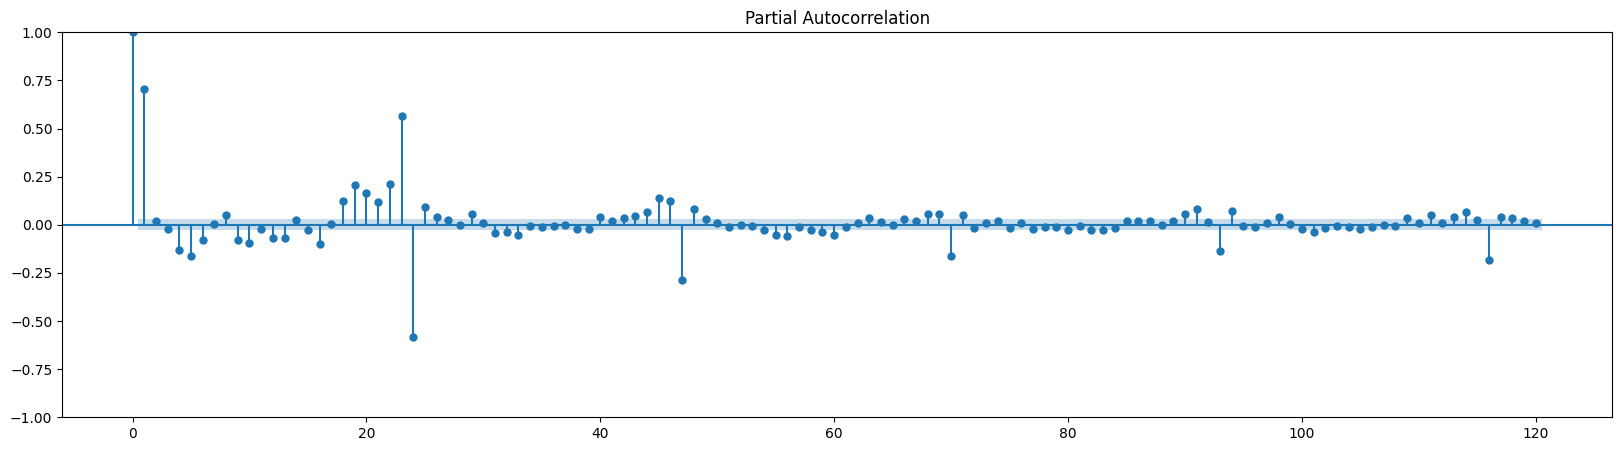

In [37]:
fig3, ax3 = plt.subplots(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(x, method="ld", lags=120, ax=ax3)
plt.show()

## VI - Décomposition

### a) La théorie

On veut décomposer $X_t$ en tant que fonction de $T_t, S_t, \epsilon_t$.

| Quantité | Signification|
| --- | --- |
| $T_t$ | Tendance (orientation à long terme), peu variable|
| $S_t$ | Composante saisonnière, fonction périodique |
| $\epsilon_t$ | Composante d'erreur, de résidus|

**Les différents modèles :**

| Modèle | Expression|
| --- | --- |
| Modèle additif | $X_t = T_t + S_t + \epsilon_t$|
| Modèle multiplicatif | $X_t = T_t * S_t * (1 + \epsilon_t)$|
| Modèle mixte | $X_t = T_t * S_t + \epsilon_t$|

### b) Application

On met toujours l'argument `period` = 21 comme hyper-paramètre de ces décompositions (car on a 21 jours de données).

#### 1. Decomposition STL avec Loess

Cela permet de récupérer les trois variables de décomposition : tendance, saisonnalité et résidus.

**Sans sommer les données :**

<Figure size 1000x800 with 0 Axes>

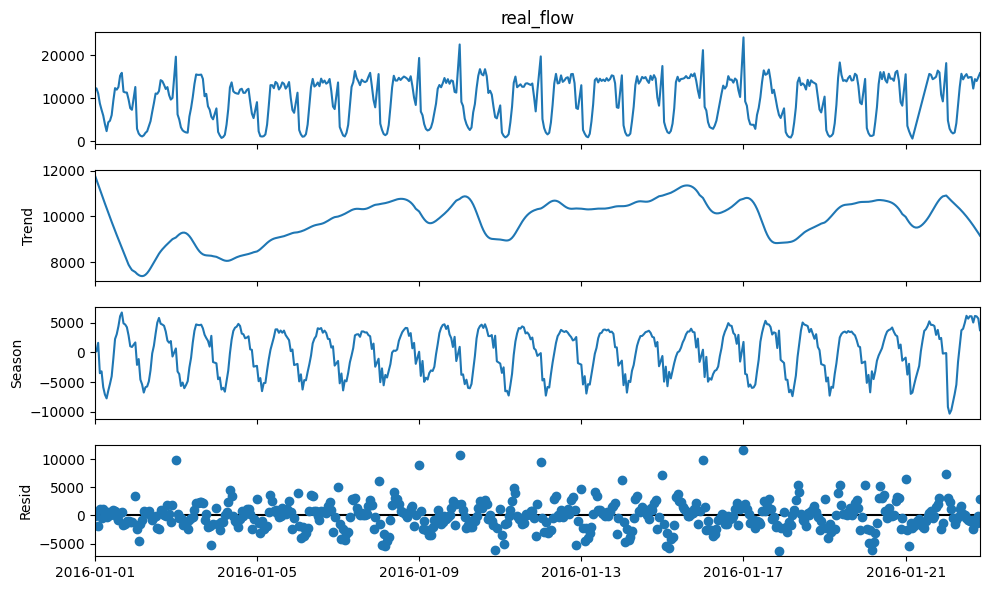

In [38]:
from statsmodels.tsa.seasonal import STL

plt.figure(figsize=(10, 8))
stl = STL(obs_df_ma.real_flow, period=21)
res = stl.fit()
plt.rcParams["figure.figsize"] = (10, 6)
fig = res.plot()

**En faisant la somme du flux :**

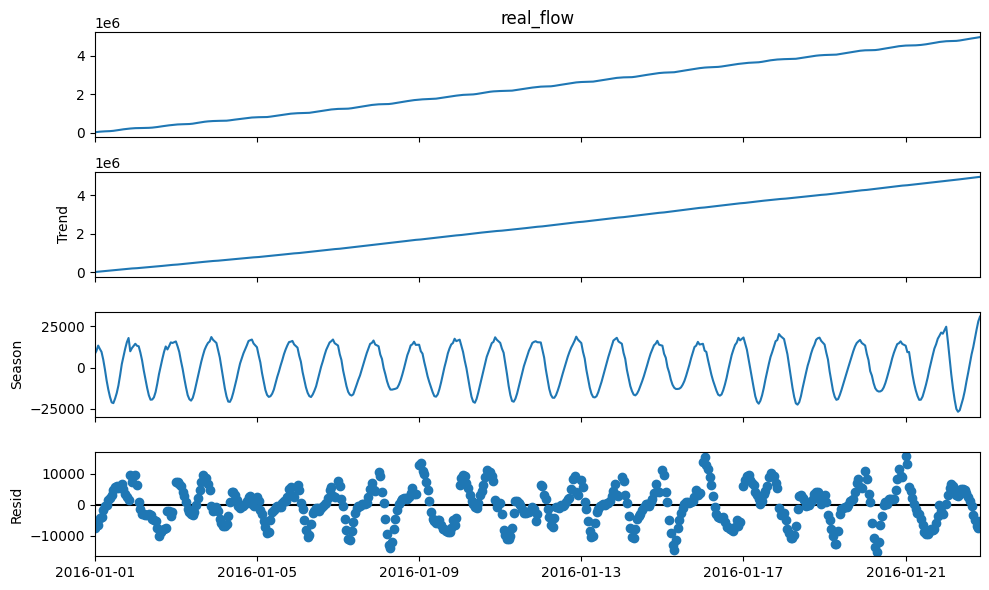

In [39]:
stl = STL(np.cumsum(obs_df_ma.real_flow), period=21)
res = stl.fit()
plt.rcParams["figure.figsize"] = (10, 6)
fig = res.plot()

### 2. Décomposition avec Moyenne Mobile

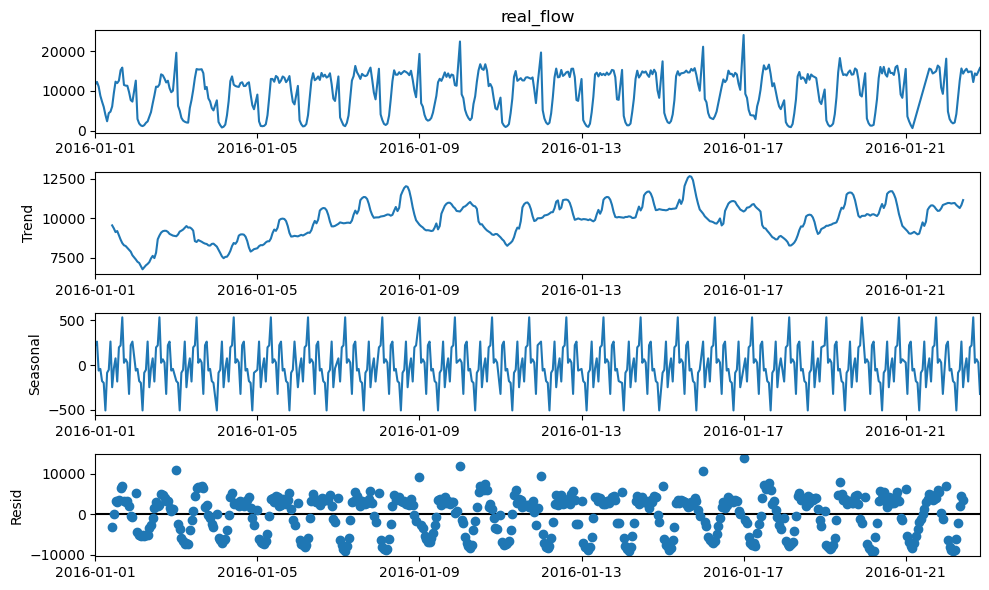

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

series_flow = obs_df_ma.real_flow.squeeze()
series_flow.index = obs_df_ma.full_time

result = seasonal_decompose(series_flow, model='additive', period=21)
plt.rcParams["figure.figsize"] = (10, 6)
result.plot()
plt.show()

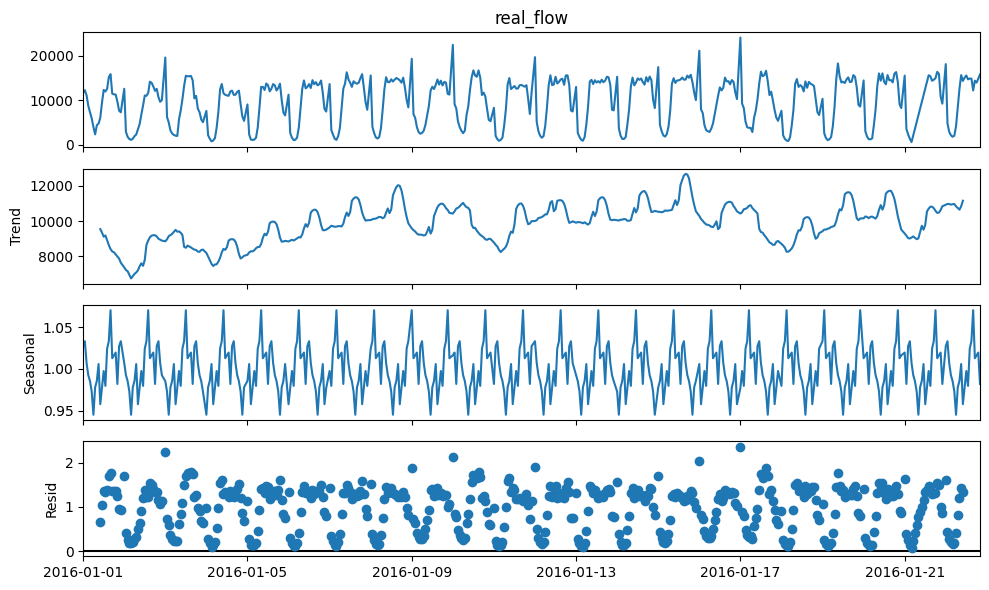

In [41]:
result_mult = seasonal_decompose(series_flow, model='multiplicative', period=21)
plt.rcParams["figure.figsize"] = (10, 6)
result_mult.plot()
plt.show()

### 3. Décomposition ETS lissage exponentiel

c:\Users\vince\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


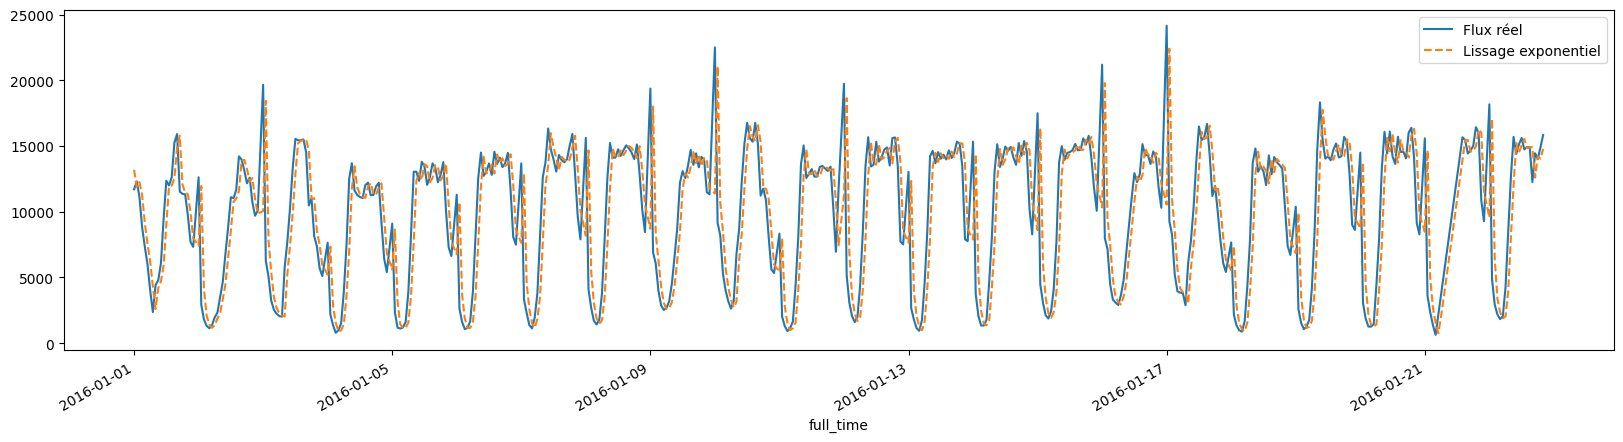

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:              real_flow   No. Observations:                  504
Model:                       ETS(ANN)   Log Likelihood               -4798.782
Date:                Sat, 03 Feb 2024   AIC                           9603.564
Time:                        11:20:55   BIC                           9616.231
Sample:                             0   HQIC                          9608.533
                                - 504   Scale                     10906916.466
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8720      0.042     20.613      0.000       0.789       0.955
initial_level    1.318e+04   3276.628      4.023      0.000    6761.427    1.96e+04
===================================================================================
Ljung-Box (Q):                        0.15   Jarque-Bera (JB):               365.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.54
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [42]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

model = ETSModel(
    series_flow
)
fit = model.fit()

plt.figure(figsize=(20,5))

plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")
fit.fittedvalues.plot(linestyle="dashed", label="Lissage exponentiel")
plt.legend()
plt.show()
fit.summary()

### 4. Décomposition TBATS

Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components.

In [17]:
from tbats import TBATS

In [18]:
estimator = TBATS(
    seasonal_periods=[24], # pour 24 h
    use_arma_errors=False,  # on peut rajouter le model arma et avoir d'autre information
    use_box_cox=False  # pour normaliser les données
)
model = estimator.fit(obs_df_ma['real_flow'])

y_forecast = model.forecast(steps= len(obs_df_ma)) # peut etre utliser pour prévoir la suite des données

print(model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: False
Seasonal periods: [24.]
Seasonal harmonics [2]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.540855
Trend (Beta): 0.010777
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [ 0.08297709 -0.017597  ]
AR coefficients []
MA coefficients []
Seed vector [1607.42459337 1229.92575088  410.39502554   92.52251767  786.4520857
  483.58349738]

AIC 11267.285770


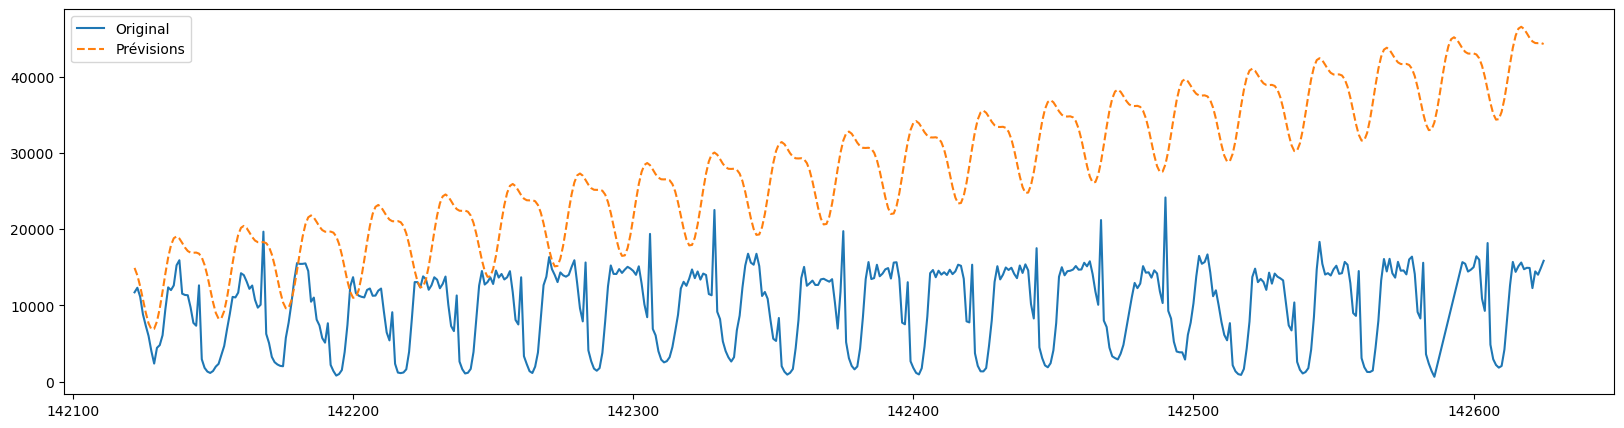

In [19]:
plt.figure(figsize=(20,5))

plt.plot(obs_df_ma['real_flow'], label='Original')

plt.plot(obs_df_ma.index, y_forecast, label='Prévisions', linestyle='dashed')

plt.legend()
plt.show()

### Qualité des modéles

| Modèle | AIC|
| --- | --- |
| TBATS | 11267|
| ETS lissage exponentiel | 9603  |
| STL avec Loess | |
| Moyenne Mobile| |

## VII - ARIMA, SARIMA

### a) ARIMA

In [33]:
from statsmodels.tsa.arima.model import ARIMA

In [51]:
model_arima = ARIMA(np.array(obs_df_ma.real_flow),
                         order=(1, 0, 0)
)

model_arima_fit = model_arima.fit()

predictions_arima = model_arima_fit.predict(start=0, end=503)

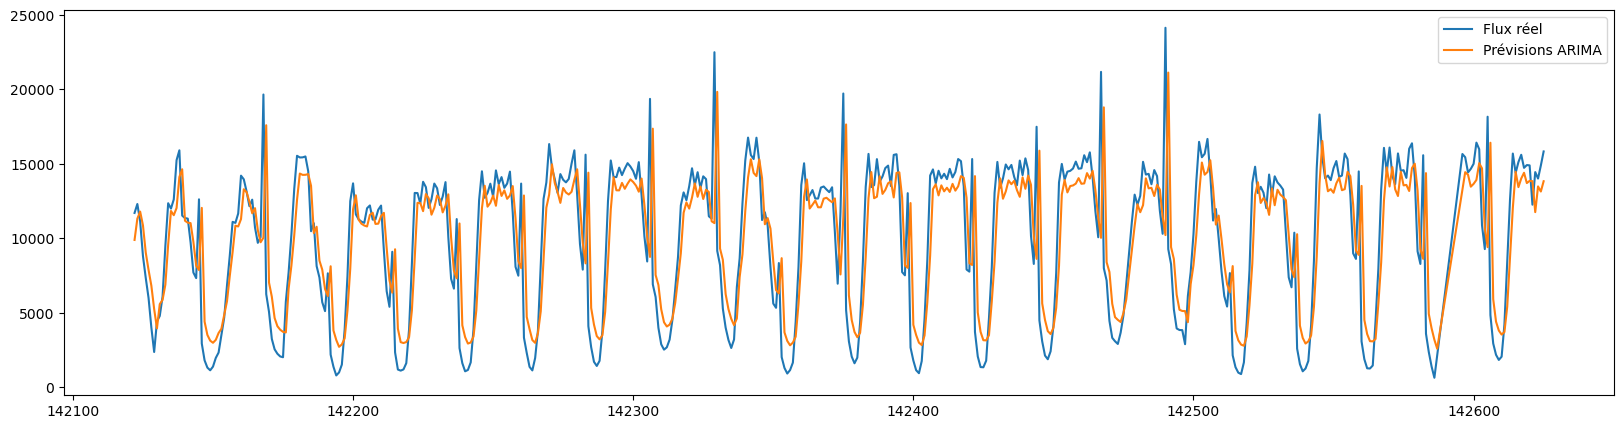

In [52]:
plt.figure(figsize=(20,5))

plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")
plt.plot(obs_df_ma.index, predictions_arima, label="Prévisions ARIMA")
plt.legend()
plt.show()

#### Recherche des meilleurs parametres

In [53]:
from pmdarima.arima import auto_arima

In [54]:
model_auto = auto_arima(np.array(obs_df_ma.real_flow))

In [55]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4775.821
Date:                Sun, 04 Feb 2024   AIC                           9557.642
Time:                        16:46:49   BIC                           9570.310
Sample:                             0   HQIC                          9562.612
                                - 504                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2079.8615    345.285      6.024      0.000    1403.115    2756.608
ar.L1          0.7904      0.026     30.472      0.000       0.740       0.841
sigma2      9.955e+06      0.166      6e+07      0.000    9.96e+06    9.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               408.69
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.53
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.7e+23. Standard errors may be unstable.
"""

Le meilleur modéle serait  le SARIMAX(1, 0, 0)

### b) SARIMA

On reprend les mêmes paramètres que ceux trouvés pour le modèle ARIMA mais cette fois on a ajoute la composante saisonnière. On prend un paramètre de périodicité égal à 24 heures.

In [241]:
model_sarima = sm.tsa.statespace.SARIMAX(np.array(obs_df_ma.real_flow),
                         order=(0, 0, 2), #changer les paramètres
                         seasonal_order=(0, 1, 1, 24))

model_sarima_fit = model_sarima.fit()

predictions_sarima1 = model_sarima_fit.predict(start=0, end=503)

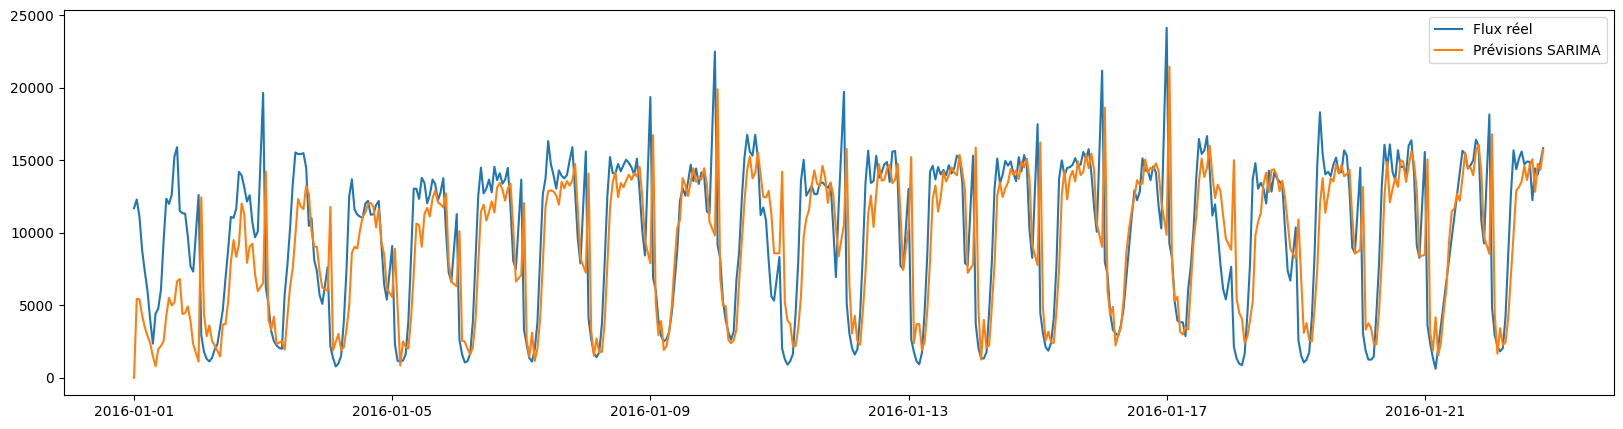

In [242]:
plt.figure(figsize=(20,5))

plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")
plt.plot(obs_df_ma.index, predictions_sarima1, label="Prévisions SARIMA")
plt.legend()
plt.show()

### c) Diagnostic a posteriori

On veut vérifier que les résidus sont bien des bruits blancs (indépendants de distribution normale)

Pour ça, on affiche la distribution des résidus et on regarde deux tests :
- Test de Ljung-Box (pour tester la corrélation entre les résidus)
- Test de Shapiro (pour la normalité)

**Modèle ARIMA :**


c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\FRO\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

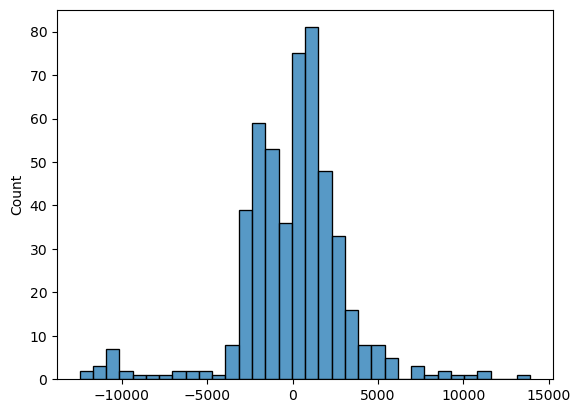

In [56]:
sns.histplot(data=model_arima_fit.resid)

Test de Ljung-Box :

In [57]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [58]:
acorr_ljungbox(model_arima_fit.resid, lags=1)

lb_stat  lb_pvalue
1  0.237725   0.625854

La p-value est supérieur à 5%, on accepte donc l'hypothèse d'indépendance des résidus.
Ils  peuvent correspondre à un bruit blanc.

Test de SHapiro-Wilk :

In [59]:
import scipy
scipy.stats.shapiro(model_arima_fit.resid)

ShapiroResult(statistic=0.9022936820983887, pvalue=1.9533668333370286e-17)

La p-value est encore une fois inférieure à 5%, on rejette donc l'hypothèse de normalité des résidus.

**Modèle SARIMA :**

<AxesSubplot:ylabel='Count'>

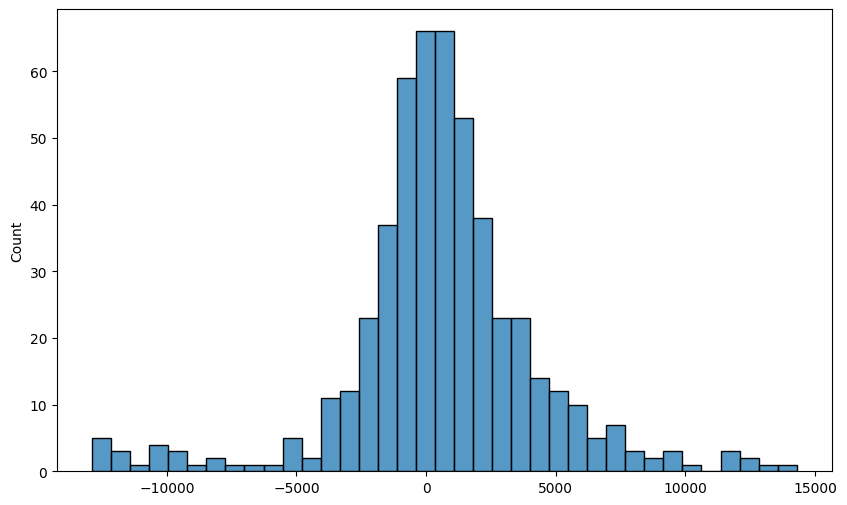

In [243]:
sns.histplot(data=model_sarima_fit.resid)

Test de Ljung-Box :

In [245]:
sm.stats.acorr_ljungbox(model_sarima_fit.resid, lags=1)

lb_stat  lb_pvalue
1  8.988978   0.002716

La p-value est inférieure à 5%, on rejette donc l'hypothèse d'indépendance des résidus.
Ils ne peuvent donc pas correspondre à un bruit blanc.

Test de SHapiro-Wilk :

In [246]:
import scipy
scipy.stats.shapiro(model_sarima_fit.resid)

ShapiroResult(statistic=0.9195032446296372, pvalue=9.344033253252844e-16)

La p-value est encore une fois inférieure à 5%, on rejette donc l'hypothèse de normalité des résidus.

## VIII - Prévisions

### a) ARIMA

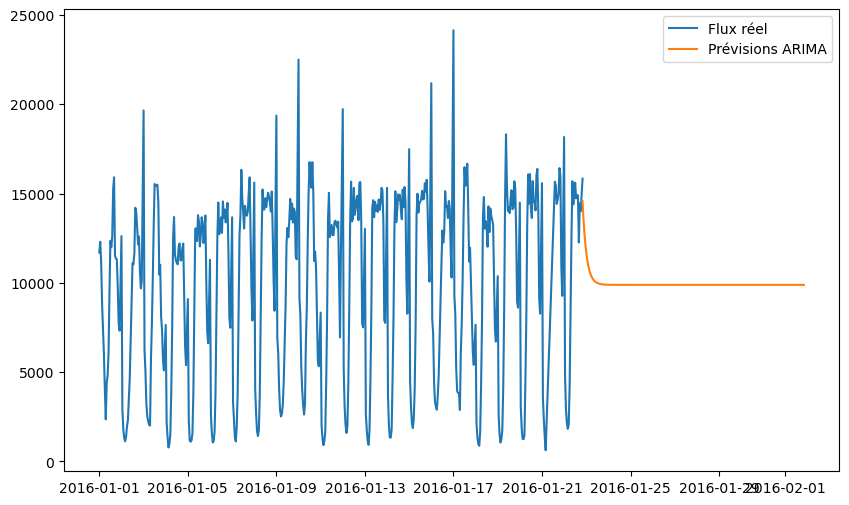

In [74]:
predictions_arima = model_arima_fit.forecast(241)

start_date_arima = obs_df_ma.index[-1]
end_date_arima = start_date_arima + pd.DateOffset(days=10)

d_range = pd.date_range(start=start_date_arima, end=end_date_arima, freq="H")

plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")
plt.plot(d_range, predictions_arima, label="Prévisions ARIMA")
plt.legend()
plt.show()

### b) SARIMA

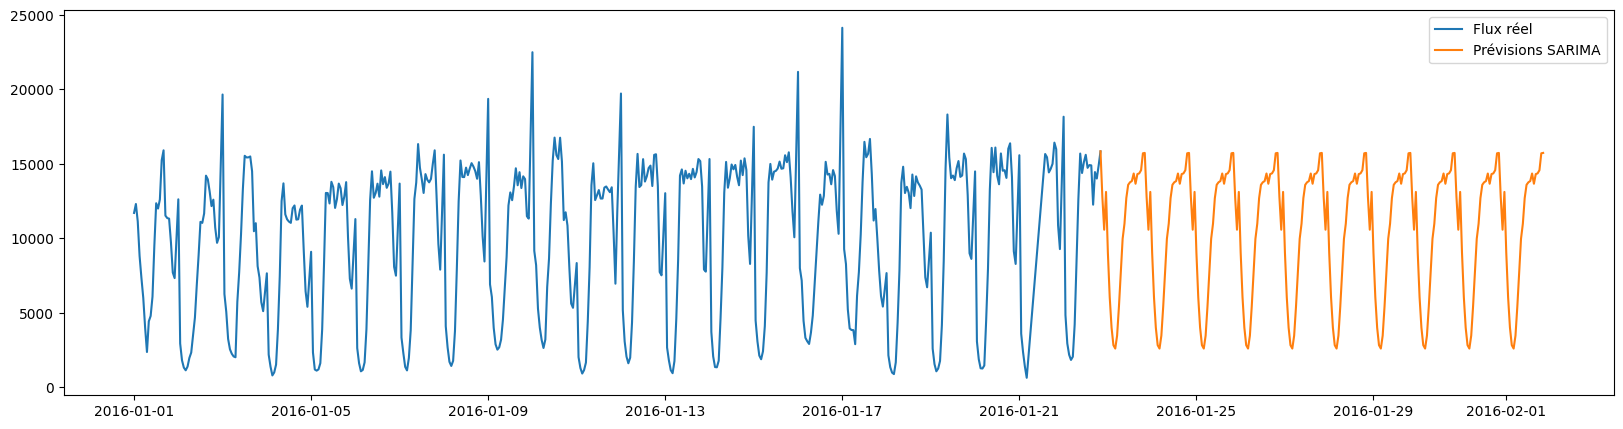

In [192]:
plt.figure(figsize=(20,5))

predictions_sarima2 = model_sarima_fit.forecast(241)

start_date_sarima = obs_df_ma.index[-1]
end_date_sarima = start_date_sarima + pd.DateOffset(days=10)

d_range = pd.date_range(start=start_date_sarima, end=end_date_sarima, freq="H")

plt.plot(obs_df_ma.index, obs_df_ma.real_flow, label="Flux réel")
plt.plot(d_range, predictions_sarima2, label="Prévisions SARIMA")
plt.legend()
plt.show()

## Conclusion

Ce projet nous a permis d'analyser de façon précise l'évolution du traffic au cours du temps, à travers l'exemple de plusieurs villes. Nous avons pu modéliser notre série temporelle à travers différents processus, en obtenant des résultats très intéressants : le modèle SARIMA par exemple est capable de bien s'ajuster aux données et de faire des prédictions qui sont cohérentes avec les données existantes.

## Perspectives

Afin de généraliser le problème, nous pourrions travailler avec la présence de covariables, pour par exemple utiliser un processus SARIMAX tenant compte de la ville et de la rue pour faire ses prédictions.
Il serait également intéressant d'incorporer la vitesse maximale de la rue comme covariable, mais cela s'avérerait assez délicat à cause de la présence de beaucoup de données manquantes dans le jeu de données.

Il serait intéressant d'ajouter des diagnostics a posteriori pour les modèles étudiés dans les autres parties (modèles paramétriques, non paramétriques).

On aurait pu découper les données par mois ou année, mais cela aurait demandé beaucoup de temps pour trier et préparer les données.

On pourrait également améliorer la partie de prédictions ARIMA, SARIMA en séparant l'échantillon de données en deux ensembles train test. On entraînerait alors les modèles sur la partie train et on comparerait les résultats entre le test et les vraies valeurs.

Enfin, on pourrait ajouter du machine learning pour modéliser la série temporelle (XGboost, réseaux de neurone, random forest, etc).